In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy

warning in stationary: failed to import cython module: falling back to numpy


# Citibike Demo

In [2]:

df = datasets.load_citibike()
datasets.add_citibike_extra_columns(df)

In [3]:
boundarylist = [('hours',0,24*1,0.5), ('tripduration_mins',0,60.0,20.0)]
output,point_row_form,area_row_form,output_row_form,bins = dp4gp.bin_dataframe(df,boundarylist,verbose=True)

#output_row_form -= np.mean(output_row_form)
#output_row_form /= np.std(output_row_form)
kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=area_row_form.shape[1],lengthscale=[10.0,1.0],variances=[1.0])
m_int = GPy.models.GPRegression(1.0*area_row_form,1.0*output_row_form[:,None],kernel)
m_int.optimize(messages=True,max_iters=50)

Bin count: 144
Data Length: 3891
Average occupancy: 27.02
Area: 10.00000
Area x Density: 515.0000
86.76% of data were not included.


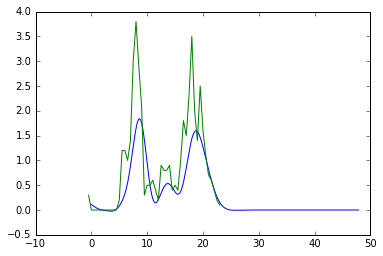

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = []
x = []
for h in np.arange(0,48,0.1):
    x.append(h)
    res,cov = m_int.predict_noiseless(np.array([[h+0.1,h,0.1,0.0]]))
    y.append(res[0][0])
plt.plot(x,np.array(y)*10) #x10 because step size during training was 0.5 x 20 = 10
plt.plot(area_row_form[area_row_form[:,2]==20,0]-1,output_row_form[area_row_form[:,2]==20])

TO DO: Include GP for DP version

# House price example

In [3]:
import pandas as pd
import dp4gp_datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp

complete = datasets.load_prices_and_postcode()

In [4]:
ys = complete['price'].values
#ys = np.log(complete['price'].values)
training_inputs = np.vstack([complete['easting'].values,complete['northing'].values]).T


In [5]:
#squash data into £200k-£700k range
ys[ys>7e5] = 7e5
ys[ys<2e5] = 2e5
#ys = np.log(ys)
#sens = np.log(7e5)-np.log(2e5)
sens = 7e5-2e5

london_east = 530000
london_north = 180000
size = 30000
samp = (training_inputs[:,0]>london_east-size) & (training_inputs[:,0]<london_east+size) & (training_inputs[:,1]>london_north-size) & (training_inputs[:,1]<london_north+size)
#import random
#samp = random.sample(range(1, len(ys)), 5000)
ys = ys[samp]
training_inputs = training_inputs[samp,:]

#use logs
#ys = np.log(ys)

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(training_inputs) #50 cities, so using about 70 inducing inputs. just london - use 10

centres = kmeans.cluster_centers_
sparse = []
for i, c in enumerate(centres):
    skip = False
    for d in centres[0:i]:
        if (np.sum((d-c)**2)<12000**2):
            skip = True
            break
    if not skip:
        sparse.append(c)
sparse = np.array(sparse)

In [7]:
test_inputs = []
step = 5000
for easting in np.arange(london_east-size,london_east+size,step):
    for northing in np.arange(london_north-size,london_north+size,step):
        test_inputs.append([easting,northing])
    
test_inputs = np.array(test_inputs)

In [11]:
pseudo_inputs = sparse
lengthscales = 9000.0
#sigma = sens
sigma = np.ones_like(ys) * sens
test_cov, normal_msense, pseudo_msense, normal_mu, psuedo_mu, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=True)

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Calculating K_NN
Calculating lambda


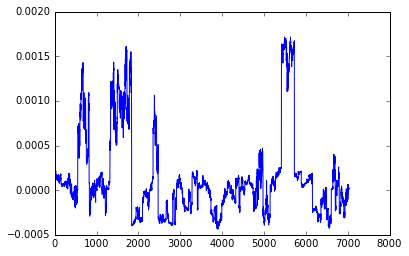

In [12]:
plt.plot(K_pseudo[0,:].T);

In [ ]:
plt.plot(K_)

In [12]:
std = np.std(K_pseudo)
weaken = np.zeros(len(ys), dtype=bool)
for it in range(5):
    weaken = weaken | (np.abs(K_pseudo[it,:])>std)

In [13]:
K_pseudo.shape

(5, 7035)

In [14]:
np.mean(np.abs(K_pseudo),0)/np.mean(np.abs(K_pseudo))

array([ 1.78475405,  1.78475405,  1.78475405, ...,  0.93044056,
        0.93793956,  0.92999552])

In [15]:
sigma = np.ones_like(ys) * sens
sigma = sigma / (np.mean(np.abs(K_pseudo),0)/np.mean(np.abs(K_pseudo)))

In [16]:
test_cov, pseudo_msense, pseudo_mu, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma)

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Calculating lambda


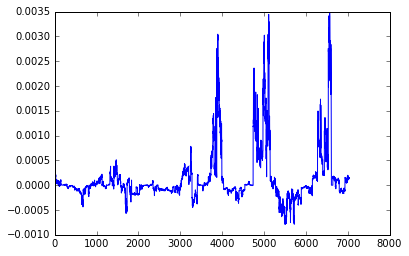

In [17]:
plt.plot(K_pseudo[0,:].T);

In [18]:
for it in range(5):
    print np.sum(K_pseudo[it,:].copy().clip(min=0))

1.38589173765
1.53282778031
1.28952416825
1.44111941747
1.36173421159


In [19]:
dp4gp.msense(K_pseudo)

1.5328277803102732

In [20]:
pseudo_msense

1.5328277803102732

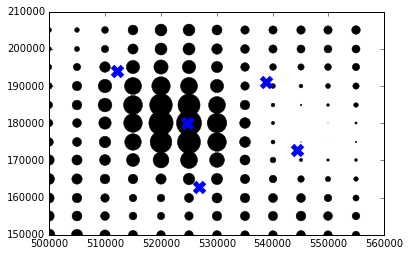

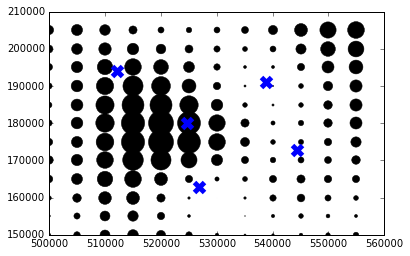

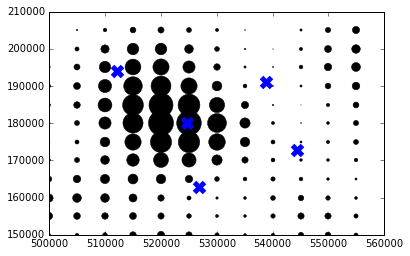

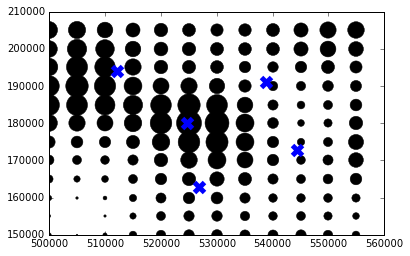

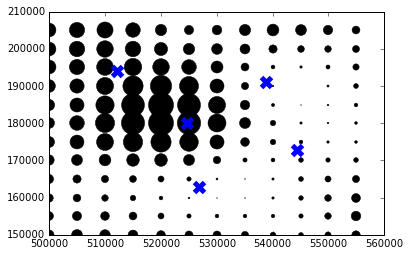

In [21]:
for it in range(5):
    plt.figure()
    preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, pseudo_msense, sens=sens, delta=0.01, eps=100.0)
    #preds = np.exp(preds)
    preds = 25*(preds - np.min(preds))/(np.max(preds)-np.min(preds))
    
    for x,y,p in zip(test_inputs[:,0],test_inputs[:,1],preds):
        plt.plot(x,y,'ko',markersize=p)
    plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)    

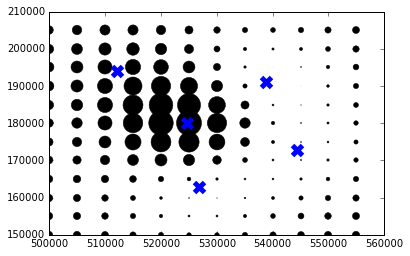

In [22]:
noiseless_preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, pseudo_msense, sens=0, delta=0.01, eps=5.0)
#noiseless_preds = np.exp(noiseless_preds)
noiseless_preds = 25*(noiseless_preds - np.min(noiseless_preds))/(np.max(noiseless_preds)-np.min(noiseless_preds))
for x,y,p in zip(test_inputs[:,0],test_inputs[:,1],noiseless_preds):
    plt.plot(x,y,'ko',markersize=p)
plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)  

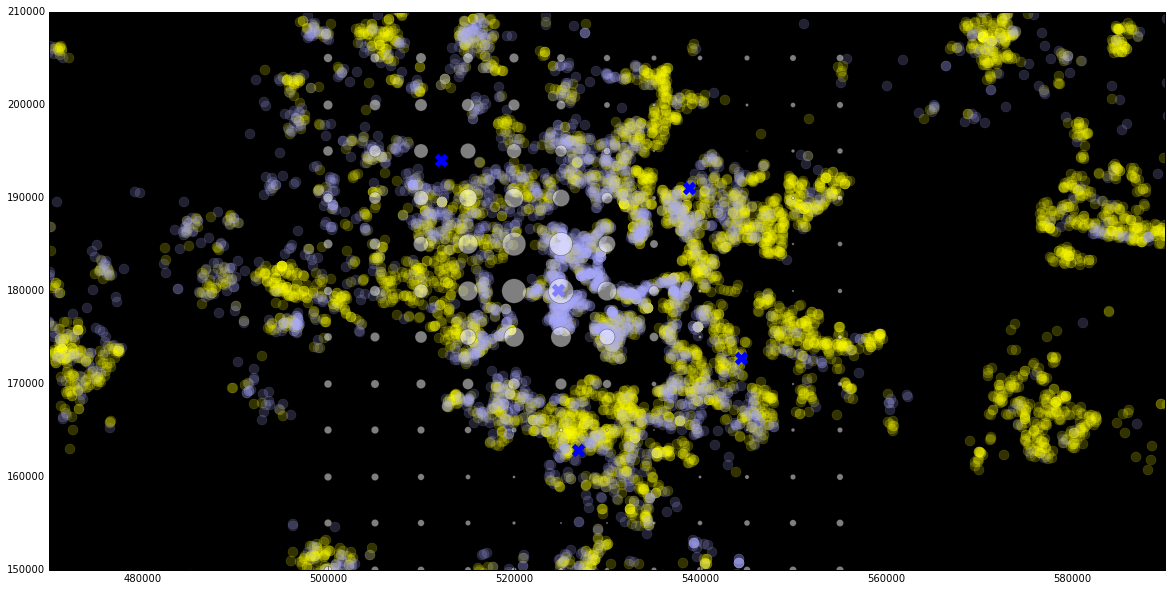

In [23]:
plt.figure(figsize=(20,10))

ranges = np.array([0,100,200,500,1000,10000]) * 1000
cols = ['red','orange','yellow','#aaaaff','white']
for rlow,rhigh,col in zip(ranges[0:-1],ranges[1:],cols):
    df = complete[(complete['price']>rlow) & (complete['price']<rhigh)]
    plt.plot(df['easting'], df['northing'],'.',alpha=0.2,markersize=20,color=col)
plt.axis('equal')
ax = plt.gca()
ax.set_axis_bgcolor('black')

plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)
plt.xlim([london_east-size,london_east+size])
plt.ylim([london_north-size,london_north+size])

for x,y,p in zip(test_inputs[:,0],test_inputs[:,1],noiseless_preds):
    plt.plot(x,y,'wo',markersize=p,alpha=0.5)

In [24]:
A = np.array([[1,2,1],[1,1,1],[3,3,3],[1,1,1]])
d = np.array([1,2,3])
D = np.diag(d)
np.dot(A,D)

array([[1, 4, 3],
       [1, 2, 3],
       [3, 6, 9],
       [1, 2, 3]])

In [25]:
A*d

array([[1, 4, 3],
       [1, 2, 3],
       [3, 6, 9],
       [1, 2, 3]])